# Wrangle OpenStreetMap Data

## Table of Contents
- [Map Area](#Map-Area)
- [Problems Encountered in the Map](#Problems-Encounterd-in-the-Map)
- [Overview of the Data](#Overview-of-the-Data)
- [Other Ideas About the Data](#Other-Ideas-About-the-Data)
- [Conclusion](#Conclusion)

## Map Area
Kalamazoo, Michigan, United States

- [Relation: Kalamazoo County (1907317) | OpenStreetMap](https://www.openstreetmap.org/relation/1907317#map=11/42.2458/-85.5299)
- [Kalamazoo Michigan County Government Website](https://www.kalcounty.com/)

While I was not born in Kalamazoo, Michigan, I have spent the last 30 years of my life here. Having worked with government released mapping data of the area in the past, I am interested to see how the open source version compares.


## Problems Encounterd in the Map
During my initial audit of the Kalamazoo County map data I identified the following problems which will be addressed here:

- [Latitude and Longitude values falling outside the range specified in the data export.](#Out-of-Bounds-Latitude/Longitude)
- [City names that do not fall within Kalamazoo County.](#City-names-not-found-in-Kalamazoo-County)
- [County names other than Kalamazoo, MI.](#County-names-other-than-Kalamazoo,-MI)
- [Non-standard street types](#Non-standard-street-types)
- [Non-standard street directions](#Non-standard-street-directions)

### Out of Bounds Latitude/Longitude
The data exported from OpenStreetMap.org included a `<bounds>` element containing the Latitude and Longitude boundaries for the exported file.

```XML
<bounds minlat="42.0697000" minlon="-85.7661000" maxlat="42.4224000" maxlon="-85.2937000"/>
```

These were compared to the `'lat'` and `'lon'` attributes found in each node element.

```XML
  <node id="27421128" lat="42.2380308" lon="-85.6283731" version="11" timestamp="2018-02-21T21:59:40Z" changeset="56563148" uid="4018842" user="Stephen214">
    <tag k="highway" v="motorway_junction"/>
    <tag k="ref" v="74B"/>
  </node>
```

The following function was used:

```python
def audit_lat_lon(value:str, bounds:list):
    val = float(value)
    if val < float(bounds[0]) or val > float(bounds[-1]):
        return val
```

4195 `'lat'` and 3713 `'lon'` attributes were found to be out of bounds. 

```
Latitude Bounds: 42.0697000 to 42.4224000
Number of out-of-bounds values: 4195
	Min out-of-bounds: 41.7384592
	Max out-of-bounds: 42.5086938

Longitude Bounds: -85.7661000 to -85.2937000
Number of out-of-bounds values: 3713
	Min out-of-bounds: -86.2912076
	Max out-of-bounds: -84.9652565
```

Once the data was loaded into a relational databse, it was easier to see the contextual information around the out of bounds node coordinates. The following query was used to view the `'city'` and `'county'` tags associated with each node.

```sql
SELECT tags.key, tags.value, COUNT(DISTINCT nodes.id) AS n
FROM nodes 
JOIN (SELECT nodes_tags.id AS node_id, nodes_tags.key, nodes_tags.value
	  FROM nodes_tags
	  UNION ALL
	  SELECT ways_nodes.node_id, ways_tags.key, ways_tags.value
	  FROM ways_tags
	  JOIN ways_nodes ON ways_tags.id = ways_nodes.id
) AS tags ON nodes.id = tags.node_id
WHERE (nodes.lat < 42.0697000 OR nodes.lat > 42.4224000 OR
	   nodes.lon < -85.7661000 OR nodes.lon > -85.2937000)
  AND (tags.key ILIKE '%county%' OR tags.key ILIKE '%city%')
GROUP BY tags.key, tags.value
ORDER BY value;
```

This yielded the following results. `'Kalamazoo, MI'` values are displayed in <span style="color:red;">red</span>. All other values fall outside of Kalamazoo County. 79 nodes have either way or node tags that contain `'Kalamazoo'`.

| key | value | n |
| --- | ----- | - |
| county_id | 149 | 89 |
| county | Allegan, MI | 178 |
| county | Barry, MI | 379 |
| city | Battle Creek | 10 |
| county | Berrien, MI:<span style="color:red;">Kalamazoo, MI</span>:Van Buren, MI | 1 |
| county | Berrien, MI:Van Buren, MI | 1 |
| county | Calhoun, MI | 662 |
| county | Calhoun, MI:<span style="color:red;">Kalamazoo, MI</span> | 5 |
| county | Calhoun, MI;<span style="color:red;">Kalamazoo, MI</span> | 5 |
| county | <span style="color:red;">Kalamazoo, MI</span> | 67 |
| county_name | St. Joseph | 89 |
| county | St. Joseph, MI | 269 |
| county | Van Buren, MI | 673 |

I investigated the 79 nodes labeled with `'Kalamazoo'`. All of them were just outside of Kalamazoo County, referencing a road or other type of way that crosses into Kalamazoo County. The remaining nodes should not be included in a dataset about Kalamazoo County. For this reason, they were deleted from the database with the following query.

```sql
DELETE FROM ways_tags WHERE ways_tags.id IN (
	SELECT ways_nodes.id FROM ways_nodes WHERE ways_nodes.node_id IN (
		SELECT nodes.id FROM nodes
		WHERE (nodes.lat < 42.0697000 OR nodes.lat > 42.4224000 OR
			   nodes.lon < -85.7661000 OR nodes.lon > -85.2937000)
	)
);
DELETE FROM ways_nodes WHERE ways_nodes.node_id IN (
	SELECT nodes.id FROM nodes
	WHERE (nodes.lat < 42.0697000 OR nodes.lat > 42.4224000 OR
		   nodes.lon < -85.7661000 OR nodes.lon > -85.2937000)
);
DELETE FROM nodes_tags WHERE nodes_tags.id IN (
	SELECT nodes.id FROM nodes
	WHERE (nodes.lat < 42.0697000 OR nodes.lat > 42.4224000 OR
		   nodes.lon < -85.7661000 OR nodes.lon > -85.2937000)
);
DELETE FROM nodes 
WHERE(nodes.lat < 42.0697000 OR nodes.lat > 42.4224000 OR
	  nodes.lon < -85.7661000 OR nodes.lon > -85.2937000);
```

### City names not found in Kalamazoo County
The tag elements nested within the node elements contain `'k'` and `'v'` tags representing various key, value pairs. In theory, the `'addr:city'` key should only contain values for cities found within Kalamazoo County. The following cities were found that are not within Kalamazoo County.

```
Cities not within Kalamazoo County
{'Mall Drive', 'scotts'}
```

Mall Drive is a locally well known street in the city of Portage, not a city. Scotts is a city in Kalamazoo County but should be capitalized. Once the data was imported into the relational database and the out of bounds coordinates were removed I ran the following query to see what cities outside of Kalmazoo County existed as either `'node'` or `'way'` tags.

```sql
SELECT tags.value, COUNT(*)
FROM (SELECT * FROM nodes_tags
	  UNION
	  SELECT * FROM ways_tags) AS tags
WHERE tags.key = 'city'
  AND tags.value NOT IN ('Augusta', 'Brady Township', 'Climax', 'Fulton', 
                         'Galesburg', 'Kalamazoo', 'Kalamazoo Township', 
                         'Nazareth', 'Parchment', 'Portage', 'Richland', 
                         'Richland Township', 'Schoolcraft', 'Scotts', 
                         'Vicksburg')
GROUP BY tags.type, tags.key, tags.value
ORDER BY count DESC;
```
| value | count |
| ----- | ----- |
| scotts | 2 |
| Kalamaazo | 1 |
| kalamazoo | 1 |
| Mall Drive | 1 |

There are three values, `'scotts'`, `'Kalamaazo'` and `'kalamazoo'`, which need correction. The remaining value, `'Mall Drive'`, needs to be removed since it was clearly entered in error. The following query handles this.

```sql
UPDATE nodes_tags SET value = 'Kalamazoo'
WHERE key = 'city' AND value IN ('Kalamaazo', 'kalamazoo');
UPDATE node_tags SET value = 'Scotts'
WHERE key = 'city'AND value = 'scotts';
UPDATE ways_tags SET value = 'Kalamazoo'
WHERE key = 'city' AND value IN ('Kalamaazo', 'kalamazoo');
UPDATE ways_tags SET value = 'Scotts'
WHERE key = 'city' AND value = 'scotts';
DELETE FROM nodes_tags WHERE key = 'city'
AND value NOT IN ('Augusta', 'Brady Township', 'Climax', 'Fulton', 'Galesburg',
				  'Kalamazoo', 'Kalamazoo Township', 'Nazareth', 'Parchment',
				  'Portage', 'Richland', 'Richland Township', 'Schoolcraft',
				  'Scotts', 'Vicksburg');
DELETE FROM ways_tags WHERE key = 'city'
AND value NOT IN ('Augusta', 'Brady Township', 'Climax', 'Fulton', 'Galesburg',
				  'Kalamazoo', 'Kalamazoo Township', 'Nazareth', 'Parchment',
				  'Portage', 'Richland', 'Richland Township', 'Schoolcraft',
				  'Scotts', 'Vicksburg');
```

### County names other than Kalamazoo, MI
The tag elements nested within the way elements also contain `'k'` and `'v'` attributes. The `'tiger:county'` element should only contain `'Kalamazoo, MI'`. The following counties not equal to `'Kalamazoo, MI'` were found:

```
Counties not equal to Kalamazoo
{'Allegan, MI',
 'Barry, MI',
 'Berrien, MI:Kalamazoo, MI:Van Buren, MI',
 'Berrien, MI:Van Buren, MI',
 'Calhoun, MI',
 'Calhoun, MI:Kalamazoo, MI',
 'Calhoun, MI;Kalamazoo, MI',
 'St. Joseph, MI',
 'Van Buren, MI'}
 ```

All of them can be found in Southwest Michigan, most of them boardering Kalamazoo County, as can be seen in the image below. 

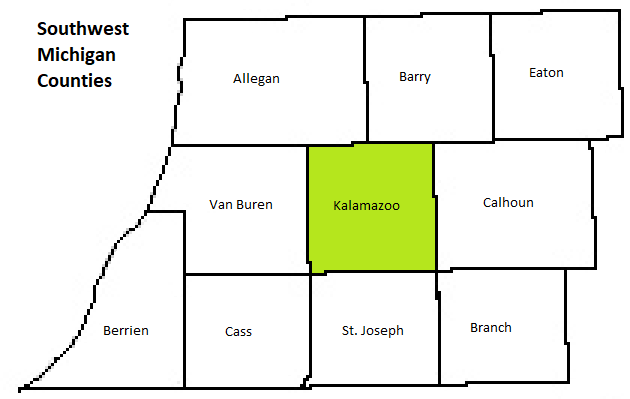

But this dataset is supposed to be about Kalamazoo County. So, the following query was used to update the database, reformatting fields containing `'Kalamazoo'`, and deleting the others.

```sql
UPDATE nodes_tags SET value = 'Kalamazoo'
WHERE key IN ('county', 'County', 'county_name')
  AND value ILIKE '%kalamazoo%';
UPDATE ways_tags SET value = 'Kalamazoo'
WHERE key IN ('county', 'County', 'county_name')
  AND value ILIKE '%kalamazoo%';
DELETE FROM nodes_tags
WHERE key IN ('county', 'County', 'county_name')
  AND value != 'Kalamazoo';
DELETE FROM ways_tags
WHERE key IN ('county', 'County', 'county_name')
  AND value != 'Kalamazoo';
```

### Non-standard street types
Continuing to look at the address tags, the `'street'` values also need some cleaning. This is actually a two part process. I used the following SQL queries to identify and correct non-standard street types.

```sql
SELECT DISTINCT tags.value
FROM (SELECT * FROM nodes_tags
	  UNION
	  SELECT * FROM ways_tags) AS tags
WHERE tags.type = 'addr' AND tags.key = 'street'
/* compare the parsed value array to the array of expected values
   only return values that don't contain any exected values */
  AND NOT(string_to_array(tags.value, ' ') &&
		  ARRAY['Alley', 'Avenue', 'Boulevard', 'Circle', 'Commons',
				'Court', 'CR', 'Crossing', 'Drive', 'Highway', 'Lane',
				'Loop', 'Parkway', 'Road', 'Square', 'Street', 'Trail', 
				'Way']);
				
/* build the table of values to replace */		   
CREATE TABLE value_mapping(old_value text, new_value text);	
INSERT INTO value_mapping VALUES
('ave', 'Avenue'), ('Ave', 'Avenue'), ('Dr', 'Drive'),
('Dr.', 'Drive'), ('Hwy', 'Highway'), ('Hwy.', 'Highway'),
('Rd', 'Road'), ('St', 'Street'), ('Sreet', 'Street');

/* perform the updates */
UPDATE nodes_tags 
SET value = REPLACE(nodes_tags.value, value_mapping.old_value, 
					value_mapping.new_value)
FROM value_mapping
WHERE value_mapping.old_value = 
	ANY(string_to_array(nodes_tags.value, ' '))
  AND nodes_tags.type = 'addr' AND nodes_tags.key = 'street';
UPDATE ways_tags 
SET value = REPLACE(ways_tags.value, value_mapping.old_value, 
					value_mapping.new_value)
FROM value_mapping
WHERE value_mapping.old_value = 
	ANY(string_to_array(ways_tags.value, ' '))
  AND ways_tags.type = 'addr' AND ways_tags.key = 'street';

/* the value mapping table is no longer needed */
DROP TABLE value_mapping;
```

### Non-standard street directions
The second part of the cleaning process for `'street'` tags is the street direction. The following query was used to find non-standard directions.

```sql
SELECT DISTINCT tags.value
FROM (SELECT * FROM nodes_tags
	  UNION
	  SELECT * FROM ways_tags) AS tags
WHERE tags.type = 'addr' AND tags.key = 'street'
/* compare the parsed value array to the array of expected values
   only return values that don't contain any exected values */
  AND NOT(string_to_array(tags.value, ' ') &&
		  ARRAY['North', 'South', 'East', 'West'])
  AND string_to_array(tags.value, ' ') && ARRAY['N', 'S', 'E', 'W'];
```

It was neccesary to filter the query in both directions to prevent correcting a street name like `'East W Avenue'` to `'East West Avenue'`. The following queries were used to correct the identified issues. The approach taken is nearly identical to what was used for correcting street types.

```sql
/* build the table of values to replace */
CREATE TABLE value_mapping (old_value text, new_value text);
INSERT INTO value_mapping VALUES
('N', 'North'), ('S', 'South'), ('E', 'East'), ('W', 'West');

/* perform the updates */
UPDATE nodes_tags
SET value = REPLACE(nodes_tags.value, value_mapping.old_value, value_mapping.new_value)
FROM value_mapping
WHERE value_mapping.old_value = 
        ANY(string_to_array(nodes_tags.value, ' '))
  AND value_mapping.new_value != 
        ANY(string_to_array(nodes_tags.value, ' '))
  AND nodes_tags.type = 'addr' AND nodes_tags.key = 'street';
UPDATE ways_tags
SET value = REPLACE(ways_tags.value, value_mapping.old_value, value_mapping.new_value)
FROM value_mapping
WHERE value_mapping.old_value = 
        ANY(string_to_array(ways_tags.value, ' '))
  AND value_mapping.new_value != 
        ANY(string_to_array(ways_tags.value, ' '))
  AND ways_tags.type = 'addr' AND ways_tags.key = 'street';
  
/* the value mapping table is no longer needed */
DROP TABLE value_mapping;
```

> It should be noted that this is not a robust solution. It works for the dataset I am cleaning. However, if this dataset contained the street name `'E W Avenue'`, it would be converted to `'East West Avenue'` instead of `'East W Avenue'` as it should be.

## Overview of the Data
This section will give an overview of the data and files produced during the data wrangling process.
  
Below is information output about the OpenStreetMap (OSM) file that was originally extracted. The file is approximately 139MB.

```
dir "*.osm" /-N

map      osm        138,725,044 01/16/2022  09:46 PM
               1 File(s)    138,725,044 bytes
```

The following output contains all of the python scripts which were used while auditing the OSM data. `helpers.py` includes all of the functions used in more than one audit script. `load_sql.py` was used to import and parse the OSM file into a buffer object, from which it was read into the PostgreSQL tables. The remaining files were used to audit each element type.

```
dir "*.py" /-N /W

helpers.py     load_sql.py    nodes.py       node_tags.py   ways.py        way_nodes.py
way_tags.py
               7 File(s)         19,909 bytes
```

Each of the python scripts used to audit the different elements types also outputs a text file containing the findings. They are listed below.

```
dir "*.txt" /-N /W

node_audit.txt    node_tag_audit.txt    way_audit.txt    way_node_audit.txt
way_tag_audit.txt
               5 File(s)         22,939 bytes
```

The final PostgreSQL database, after all cleaning was performed, is shown below with its final size totalling approximately 80MB. It was surprising to see that the OSM file was actually 1.7 times the size of the SQL database file.

```
dir "*.pgsql"

01/17/2022  08:23 PM        79,948,337 osm.pgsql
               1 File(s)     79,948,337 bytes
```

And finally, the total record counts found in the database can be seen below.

```sql
SELECT table_catalog, table_schema, table_name,
	CASE table_name
		WHEN 'nodes' THEN (SELECT COUNT(*) FROM nodes)
		WHEN 'nodes_tags' THEN (SELECT COUNT(*) FROM nodes_tags)
		WHEN 'ways' THEN (SELECT COUNT(*) FROM ways)
		WHEN 'ways_nodes' THEN (SELECT COUNT(*) FROM ways_nodes)
		WHEN 'ways_tags' THEN (SELECT COUNT(*) FROM ways_tags)
	END AS record_count
FROM information_schema.tables AS tables
WHERE tables.table_catalog = 'osm'
  AND tables.table_schema = 'public'
```

| table_catalog | table_schema | table_name | record_count |
| ------------- | ------------ | ---------- | ------------ |
| osm | public | nodes | 619280 |
| osm | public | nodes_tags | 27946 |
| osm | public | ways | 75017 |
| osm | public | ways_nodes | 719093 |
| osm | public | ways_tags | 198481 |

## Other Ideas About the Data

### Field Harmonization

There are a number of concepts throughout the data which are inconsistently documented. For instance, there are at least three different types of location tags: `'tiger'`, `'addr'`, and `'gnis'`; all with overlapping fields. Ideally, these would be harmonized into a single set of location fields. There is a similar situation going on with the various name types an keys.

### Top Ten Cities and Towns by Population

```sql 
SELECT MAX(CASE key WHEN 'name' THEN value END) town
	,MAX(CASE key WHEN 'population' THEN 
		 (STRING_TO_ARRAY(value, ';'))[1] END)::INT population
FROM nodes_tags
GROUP BY id
HAVING MAX(CASE key WHEN 'name' THEN value END) IS NOT NULL
   AND MAX(CASE key WHEN 'population' THEN value END) IS NOT NULL
ORDER BY population DESC LIMIT 10;
```

| town | population |
| ---- | ---------- |
| Kalamazoo | 72161 |
| Portage | 45236 |
| Westwood | 8653 |
| Eastwood | 6340 |
| Pavilion | 5667 |
| Alamo | 3963 |
| Vicksburg | 2172 |
| Galesburg | 1920 |
| Parchment | 1797 |
| Schoolcraft | 1495 |

Kalamazoo and Portage are the two major cities in Kalamazoo County, so it makes sense that they have the highest populations. The rest are all either neighborhoods or townships, so it makes sense that they would be significantly smaller.

### Top Ten Churches by Size (node count)

```sql
SELECT MAX(CASE key WHEN 'name' THEN value END) name,
	COUNT(DISTINCT ways_nodes.node_id) node_count
FROM ways_nodes
JOIN ways_tags ON ways_nodes.id = ways_tags.id
GROUP BY ways_nodes.id
HAVING MAX(CASE key WHEN 'name' THEN value END) IS NOT NULL
   AND MAX(CASE key WHEN 'amenity' THEN value END) = 'place_of_worship'
ORDER BY node_count DESC LIMIT 10;
```

| name | node_count |
| --- | --- |
| The Cathedral at Valley Family Church | 103 |
| Calvary Bible Church | 67 |
| Grace Harbour Church | 57 |
| Second Reformed Church | 54 |
| Berean Baptist Church | 48 |
| Texas Corners Bible Church | 44 |
| Saint Martin of Tours Church | 38 |
| Saint Michael Lutheran Church | 34 |
| Valley Family Church | 32 |
| The Church of Jesus Christ of Latter-day Saints | 30 |

Valley Family Church and Calvary Bible Church are officially known as "Megachurches" according to the [Hartford Institute for Religion Research](http://hirr.hartsem.edu/cgi-bin/mega/db.pl?db=default&uid=default&view_records=1&ID=*&sb=4&State=MI), so it is only logical that they would appear at the top of the list. 

### Top Ten Fast Food Restaurants (way count)

```sql
SELECT name, COUNT(DISTINCT id) way_count
FROM (
	SELECT ways_nodes.id, 
		MAX(CASE key WHEN 'name' THEN value END) name
	FROM ways_nodes
	JOIN ways_tags ON ways_nodes.id = ways_tags.id
	GROUP BY ways_nodes.id
	HAVING MAX(CASE key WHEN 'name' THEN value END) IS NOT NULL
	   AND MAX(CASE key WHEN 'amenity' THEN value END) = 'fast_food'
) base
GROUP BY name
ORDER BY way_count DESC LIMIT 10;
```

| name | node_count |
| --- | --- |
| McDonald's | 13 |
| Taco Bell | 7 |
| Arby's | 6 |
| Wendy's | 6 |
| Burger King | 5 |
| Culver's | 3 |
| Lee's Famous Recipe Chicken | 2 |
| Jimmy John's | 2 |
| KFC | 2 |
| Subway | 2 |

Considering these are all well known chains, it is not surprising that the all appear on the top 10 list. I do feel like the counts are low however. I can think of way more than two Subways and at least four Jimmy John's in Kalamazoo County. 

## Conclusion

Overall, there is still a lot that could be done with this data regarding additional field harmonization and standardization. As mentioned before, the various name and address/location fields are inconsistent and come from scattered sources. That being said, there was a fair amount of information which was made more accessible via this cleaning process. With the general address fields now standardized, an automated process could be implemented to harmonize the tiger, gnis, and regular way tags as they pertain to individual addresses.